<a href="https://colab.research.google.com/github/Mubarok982/pneumonia-detector/blob/main/Latihan_Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Library**

## **Library umum**

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

## **library untuk pemrosesan data gambar**

In [2]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.exposure import adjust_gamma

## **library untuk membangun model**

In [3]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D,  MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **Mencetak versi tensorflow yang sedang di gunakan**

In [5]:
print(tf.__version__)

2.19.0


#**Load Dataset**

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"rizqymubarok","key":"2d8c6410d136c31f34213f70571b515a"}'}

In [7]:
!pip install --upgrade kaggle --quiet

In [8]:
!rm -rf chest_xray/

In [9]:
rm -f labeled-chest-xray-images.zip


In [10]:
# Download kaggle dataset and unzip  file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [11]:
#Pengecekan dan penghapusan gambar rusak
dataset_path = "chest_xray"

bad_images = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = cv2.imread(file_path)
            if img is None:
                raise ValueError("Tidak bisa dibaca oleh OpenCV")
        except Exception as e:
            bad_images.append(file_path)
            print(f"[HAPUS] {file_path} -> {e}")
            os.remove(file_path)

print(f"Total gambar rusak dihapus: {len(bad_images)}")

Total gambar rusak dihapus: 0


#**Data Preparation**

In [12]:
#Direktori untuk train dan test
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'

#Direktori untuk dataset gabungan
combned_dir = '/content/chest_xray/dataset'
os.makedirs(combned_dir, exist_ok=True)

## **Menyalin file dan folder**

In [13]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
  category_dir = os.path.join(train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combned_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
  category_dir = os.path.join(test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combned_dir, category), dirs_exist_ok=True)

##**Dataset Checking**

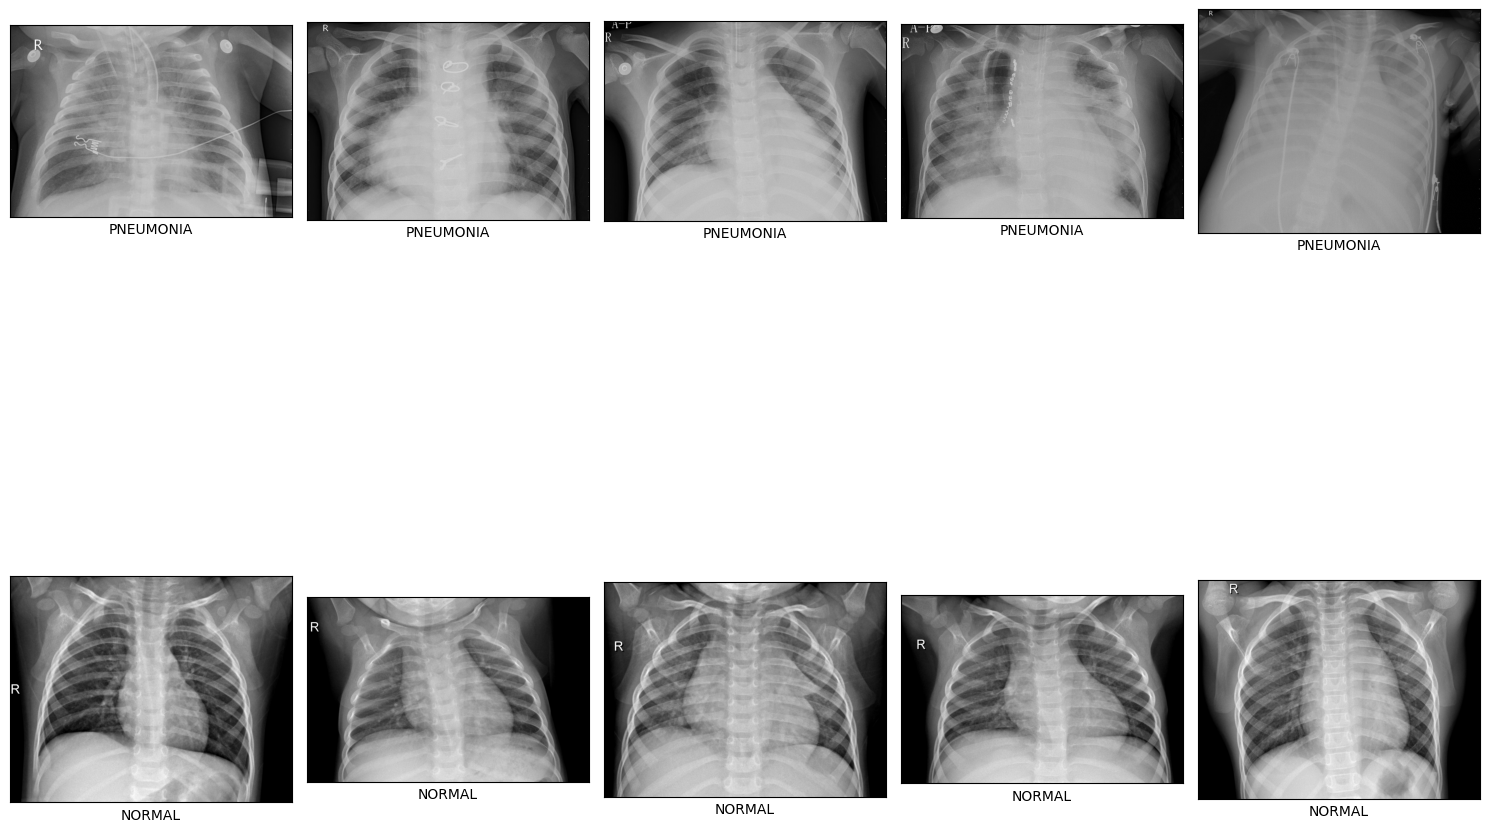

In [14]:
# Membuat kamus yang menyimpan setipa kelas dalam data
lung_image = {} # Initialize as a dictionary

#tentukan path sumber train
path = '/content/chest_xray/'
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
  # Check if the item is a directory before listing its contents
  if os.path.isdir(os.path.join(path_sub, i)):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
path_sub =  '/content/chest_xray/dataset'

# Import matplotlib and PIL for plotting
import matplotlib.pyplot as plt
from PIL import Image


# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    # Ensure the key exists in the dictionary before accessing it
    if class_name in lung_image:
        images = np.random.choice(lung_image[class_name], 5, replace=False)

        for j, image_name in enumerate(images):
            img_path = os.path.join(path_sub, class_name, image_name)
            img = Image.open(img_path).convert("L")
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

## **Plot Distribusi**

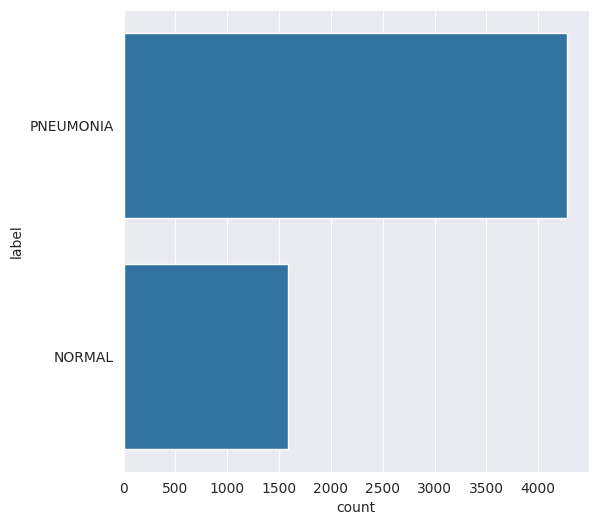

In [15]:
#path sumber
lung_path = '/content/chest_xray/dataset'

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "label": labels})

#Plot distribusi gambar di setiap kelas
import seaborn as sns
Label  = distribution_train['label']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#**Data Augmentation**


Proses augmentasi gambar adalah teknik yang digunakan untuk membuat variasi baru dari setiap gambar dalam dataset, sehingga model memiliki lebih banyak variasi untuk dipelajari. Ini membantu mencegah overfitting, di mana model terlalu terbiasa dengan data pelatihan dan tidak dapat menggeneralisasi dengan baik ke data baru.

Berikut adalah beberapa strategi augmentasi gambar yang dapat kita terapkan:

- `anticlockwise_rotation` adalah ketika gambar diputar ke arah berlawanan dengan arah jarum jam.
- `clockwise_rotation` adalah ketika gambar diputar ke arah searah dengan arah jarum jam.
- `flip_up_down` adalah ketika gambar dibalik secara vertikal dari atas ke bawah.
- `sheared` adalah ketika gambar diberikan efek pergeseran acak.
- `blur` adalah ketika gambar diberikan efek kabur atau blur.
- `wrap_shift` adalah ketika gambar diberikan efek pergeseran melengkung.
- `brightness` adalah ketika gambar diberikan efek peningkatan kecerahan.

In [16]:
def ensure_rgb(img):
    """Pastikan gambar punya 3 channel RGB."""
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    if img.ndim == 2:  # grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.ndim == 3 and img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_blur(img, (3, 3))  # Ukuran kernel blur bisa disesuaikan
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    img = ensure_rgb(img.numpy())  # pastikan 3 channel
    datagen = ImageDataGenerator(shear_range=0.2)
    img = img.reshape((1,) + img.shape)  # (1, H, W, C)
    img = next(datagen.flow(img, batch_size=1))[0]
    return tf.convert_to_tensor(img, dtype=tf.float32)

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    img = ensure_rgb(img.numpy())  # pastikan 3 channel
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = img.reshape((1,) + img.shape)  # (1, H, W, C)
    img = next(datagen.flow(img, batch_size=1))[0]
    return tf.convert_to_tensor(img, dtype=tf.float32)

In [17]:
import os
import random
import time
from skimage import io, img_as_ubyte
import cv2

# Variabel transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "/content/chest_xray/dataset/NORMAL"
augmented_path = "/content/chest_xray/dataset/NORMAL_augmented"

os.makedirs(augmented_path, exist_ok=True)

# Kumpulkan semua path gambar
images = [os.path.join(images_path, im) for im in os.listdir(images_path)]

images_to_generate = 2000
i = 1

# Timer mulai
start_time = time.time()
max_duration = 2 * 60 * 60  # 2 jam dalam detik

while i <= images_to_generate:
    # Cek apakah sudah lewat 2 jam
    if time.time() - start_time > max_duration:
        print("⏰ Waktu proses sudah lebih dari 2 jam. Menghentikan augmentasi...")
        break

    image_path = random.choice(images)
    try:
        original_image = io.imread(image_path)

        transformation_count = random.randint(1, len(transformations))
        transformed_image = original_image

        for _ in range(transformation_count):
            key = random.choice(list(transformations))
            transformed_image = transformations[key](transformed_image)

        new_image_path = f"{augmented_path}/augmented_image_{i}.jpg"
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i += 1

    except Exception as e:
        print(f"Skip {image_path}: {e}")

print(f"Augmentasi selesai! Total gambar dibuat: {i-1}")


Streaming output truncated to the last 5000 lines.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-3400382-0002.jpeg: 'images' must have either 3 or 4 dimensions.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-3006949-0002.jpeg: 'images' must have either 3 or 4 dimensions.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-3684474-0001.jpeg: 'images' must have either 3 or 4 dimensions.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-3178986-0001.jpeg: 'images' must have either 3 or 4 dimensions.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-1456124-0002.jpeg: 'images' must have either 3 or 4 dimensions.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-1101909-0001.jpeg: 'images' must have either 3 or 4 dimensions.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-3037101-0001.jpeg: 'images' must have either 3 or 4 dimensions.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-7123604-0001.jpeg: 'images' must have either 3 or 4 dimensions.
Skip /content/chest_xray/dataset/NORMAL/NORMAL-1702319-0001.j

### **Membuat plot**

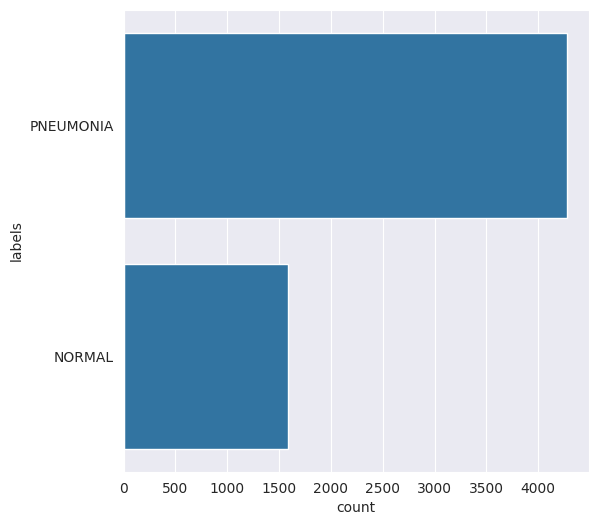

In [18]:
#path sumber
lung_path = '/content/chest_xray/dataset'

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Splitting**

In [19]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'chest_xray/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
NORMAL,1583
PNEUMONIA,4273


In [20]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [21]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [22]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 4684
test size 1172


In [23]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   NORMAL        289
       PNEUMONIA     883
train  NORMAL       1294
       PNEUMONIA    3390
dtype: int64 


                                                   path     labels    set
4248  chest_xray/dataset/PNEUMONIA/VIRUS-9564688-000...  PNEUMONIA  train
3361  chest_xray/dataset/PNEUMONIA/VIRUS-463487-0011...  PNEUMONIA  train
4263  chest_xray/dataset/PNEUMONIA/VIRUS-8917885-000...  PNEUMONIA  train
312   chest_xray/dataset/PNEUMONIA/VIRUS-9291784-000...  PNEUMONIA  train
5623  chest_xray/dataset/NORMAL/NORMAL-6433176-0001....     NORMAL   test


In [24]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "content/chest_xray/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [25]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **Image Data Generator**

In [26]:
# Definisikan  training dan test directori
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_normal = os.path.join(TRAIN_DIR + '/NORMAL')
train_pneumonia = os.path.join(TRAIN_DIR + '/PNEUMONIA')
test_normal = os.path.join(TEST_DIR + '/NORMAL')
test_pneumonia = os.path.join(TEST_DIR + '/PNEUMONIA')

print("Total gambar normal di training set: ",len(os.listdir(train_normal)))
print("Total gambar pneumonia di training set: ",len(os.listdir(train_pneumonia)))
print("Total gambar normal images di test set: ",len(os.listdir(test_normal)))
print("Total gambar pneumonia  di test set: ",len(os.listdir(test_pneumonia)))

Total gambar normal di training set:  1294
Total gambar pneumonia di training set:  3390
Total gambar normal images di test set:  289
Total gambar pneumonia  di test set:  883


In [27]:
# Membuat  ImageDataGenerator object
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 3748 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


# **Model Exp 1 - CNN Architecture (Dengan 32 Neuron di Conv Layer):**

In [28]:
model_1 = Sequential()

# lapisan kedua Convolutional layer, Batch Normalization layer, dan Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# lapisan pertama Convolutional layer, Batch Normalization layer, dan Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# lapisan ke 3 Convolutional layer, Batch Normalization layer, dan Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# lapisan pertama  Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# lapisan pertama Dropout Layer
model_1.add(Dropout(0.5))
# la[isan ke dua] Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# lapisan ke dua Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer
model_1.add(Dense(1, activation='sigmoid'))
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary dari Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [29]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 53.4 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.7028 - loss: 1.6367 - val_accuracy: 0.7244 - val_loss: 7.8105
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8664 - loss: 0.4039 - val_accuracy: 0.7244 - val_loss: 33.6303
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.9168 - loss: 0.2784 - val_accuracy: 0.7244 - val_loss: 42.5706
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9250 - loss: 0.2405 - val_accuracy: 0.7553 - val_loss: 5.2188
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.9393 - loss: 0.1906 - val_accuracy: 0.9455 - val_loss: 0.4086
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9450 - loss: 0.1954 - val_accuracy: 0.7585 - val_loss: 5.2495
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9545 - loss: 0.1965 - val_accuracy: 0.9594 - val_loss: 0.1754
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.9544 - loss: 0.1223 - val_ac

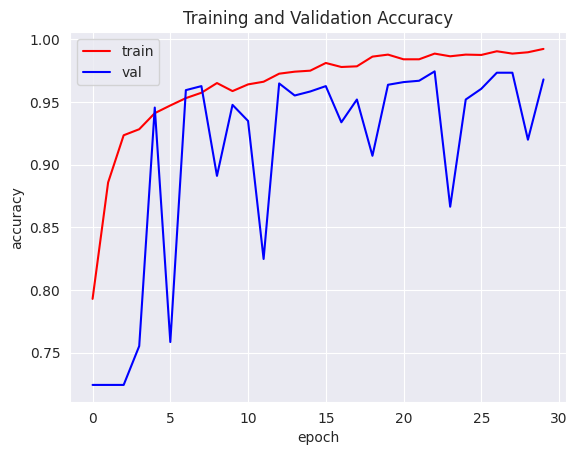

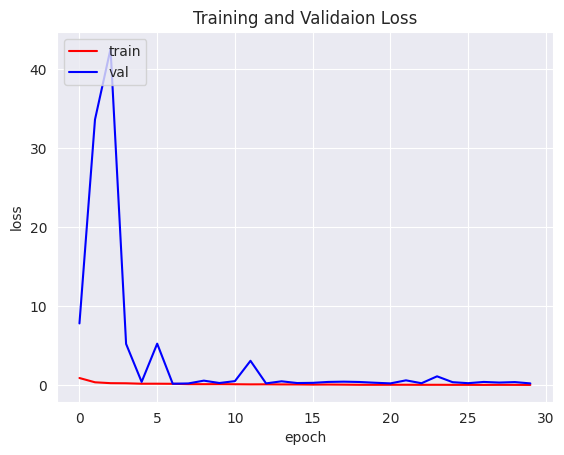

In [30]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.9481    0.9481    0.9481       289
   Pneumonia     0.9830    0.9830    0.9830       883

    accuracy                         0.9744      1172
   macro avg     0.9656    0.9656    0.9656      1172
weighted avg     0.9744    0.9744    0.9744      1172



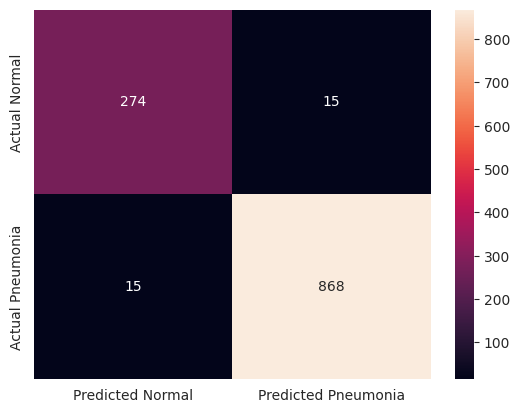

In [31]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 2 - Arsitektur CNN Menggunakan 64 Neuron di Lapisan Konvolusi:**
1. Tambahkan 3 lapisan konvolusi di mana setiap lapisan memiliki 64 neuron, filter pertama 3x3, filter kedua 4x4, filter ketiga 7x7, lapisan max pool 2x2, dan lapisan normalisasi batch.
2. Tambahkan lapisan flatten, lapisan dense, dan lapisan dropout.
3. Gunakan Relu sebagai fungsi aktivasi.
4. Ambil fungsi kerugian sebagai binary cross-entropy.
5. Ambil rmsprop sebagai optimizer.
6. Gunakan early stopping dengan kesabaran dua epoch dan monitor kerugian atau akurasi validasi.
7. Cobalah dengan 30 epoch.
8. Latih model menggunakan generator dan uji akurasi data uji di setiap epoch.
9. Plot akurasi pelatihan dan validasi, serta kerugian.
10. Amati presisi, recall, dan F1-score untuk semua kelas dan tentukan apakah kelas model sudah baik.

In [32]:
# tf.keras.backend.clear_session()

model_2 = Sequential()

# lapis pertama Convolutional layer, Batch Normalization layer, dan Pooling layer
model_2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# lapis kedua Convolutional layer, Batch Normalization layer, dan Pooling layer
model_2.add(Conv2D(64, (4, 4),padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# lapis ketiga Convolutional layer, Batch Normalization layer, dan Pooling layer
model_2.add(Conv2D(64, (7, 7), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# Flatten layer
model_2.add(Flatten())
# lapis pertama Dense Layer
model_2.add(Dense(128, activation = 'relu'))
# lapis pertama Dropout Layer
model_2.add(Dropout(0.5))
# lapis kedua Dense Layer
model_2.add(Dense(64, activation = 'relu'))
# lapis ke dua Dropout Layer
model_2.add(Dropout(0.3))
# Final Dense layer
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary dari Model Architecture
print(model_2.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,930,433 (11.18 MB)

 Trainable params: 2,930,049 (11.18 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [2]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_2 = model_2.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

NameError: name 'os' is not defined

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_2 = model_2.predict(test_generator,verbose=0)
preds_2 = preds_2.copy()
preds_2[preds_2 <= 0.5] = 0
preds_2[preds_2 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_2, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_2,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 3 - Arsitektur CNN Menggunakan 128 Neuron di Lapisan Conv:**
1. Tambahkan 3 lapisan konvolusi dengan masing-masing lapisan memiliki 128 neuron, filter pertama 3x3, filter kedua 4x4, filter ketiga 7x7, lapisan max pool 2x2, dan lapisan normalisasi batch.
2. Tambahkan lapisan flatten, lapisan dense, dan lapisan dropout.
3. Gunakan Relu sebagai fungsi aktivasi.
4. Ambil fungsi kehilangan sebagai binary cross-entropy.
5. Ambil rmsprop sebagai optimizer.
6. Gunakan early stopping dengan kesabaran dua epoch dan pantau kehilangan atau akurasi validasi.
7. Cobalah dengan 30 angka epoch.
8. Latih model menggunakan generator dan uji akurasi data uji pada setiap epoch.
9. Plot akurasi pelatihan dan validasi, serta kehilangan.
10. Amati presisi, recall, F1-score untuk semua kelas dan tentukan apakah kelas model baik.

In [ ]:
# tf.keras.backend.clear_session()

model_3 = Sequential()

# lapis pertama Convolutional layer, Batch Normalization layer, dan Pooling layer
model_3.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# lapis kedua Convolutional layer, Batch Normalization layer, dan Pooling layer
model_3.add(Conv2D(128, (4, 4),padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# lapis ketiga Convolutional layer, Batch Normalization layer, dan Pooling layer
model_3.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# Flatten layer
model_3.add(Flatten())
# lapisan pertama  Dense Layer
model_3.add(Dense(128, activation = 'relu'))
# lapisan pertama Dropout Layer
model_3.add(Dropout(0.5))
# lapisan ke dua Dense Layer
model_3.add(Dense(64, activation = 'relu'))
# lapisna ke dua Dropout Layer
model_3.add(Dropout(0.3))
# Final Dense layer
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary dari Model Architecture
print(model_3.summary())

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_3 = model_3.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

In [ ]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_3 = model_3.predict(test_generator,verbose=0)
preds_3 = preds_3.copy()
preds_3[preds_3 <= 0.5] = 0
preds_3[preds_3 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_3, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_3,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 4 - Arsitektur CNN (Menggunakan Learning Rate 0.001):**
Dari hasil evaluasi kedua model, kita dapat mempertimbangkan beberapa metrik kinerja utama seperti presisi, recall, dan f1-score untuk menentukan model terbaik berdasarkan kebutuhan tertentu.
Model 1:

Presisi Normal: 0.9941 <br>
Recall Normal: 0.9479 <br>
F1-score Normal: 0.9704 <br>
Presisi Pneumonia: 0.9587 <br>
Recall Pneumonia: 0.9954 <br>
F1-score Pneumonia: 0.9767 <br>
Akurasi: 0.9739

Model 2:

Presisi Normal: 0.9691 <br>
Recall Normal: 0.9732 <br>
F1-score Normal: 0.9712 <br>
Presisi Pneumonia: 0.9779 <br>
Recall Pneumonia: 0.9745 <br>
F1-score Pneumonia: 0.9762 <br>
Akurasi: 0.9739 <br>
Kedua model memiliki akurasi yang sama (0.9739), tetapi ada perbedaan dalam metrik presisi, recall, dan f1-score untuk kelas Normal dan Pneumonia.

<br>Pertimbangan:
Jika kita fokus pada kelas Normal:
* Model 1 memiliki presisi yang lebih tinggi (0.9941 vs 0.9691).
* Model 1 memiliki recall yang sedikit lebih rendah (0.9479 vs 0.9732).
* F1-score untuk kelas Normal sedikit lebih tinggi di Model 1 (0.9704 vs 0.9712).
Jika kita fokus pada kelas Pneumonia:
* Model 1 memiliki recall yang lebih tinggi (0.9954 vs 0.9745).
* Presisi untuk kelas Pneumonia hampir sama antara kedua model.
* F1-score untuk kelas Pneumonia sedikit lebih tinggi di Model 1 (0.9767 vs 0.9762).
<br>Kesimpulan:* Jika prioritas utama adalah mengoptimalkan deteksi Pneumonia (kelas minoritas), Model 1 mungkin lebih diinginkan karena memiliki recall yang lebih tinggi untuk kelas Pneumonia.* Jika perhatian utama adalah untuk mempertahankan presisi klasifikasi Normal, Model 1 juga memberikan hasil yang lebih baik dalam hal presisi untuk kelas Normal.<br>

1. Tambahkan 3 lapisan konvolusi dengan setiap lapisan memiliki 32 neuron, filter pertama 3x3, filter kedua 4x4, filter ketiga 7x7, lapisan max pool 2x2, dan lapisan normalisasi batch.
2. Tambahkan lapisan flatten, lapisan padat, dan lapisan dropout.
3. Gunakan Relu sebagai fungsi aktivasi.
4. Ambil fungsi loss sebagai binary cross-entropy.
5. Ambil rmsprop sebagai optimizer dengan learning rate 0.001.
6. Gunakan early stopping dengan kesabaran dua epoch dan monitor loss atau akurasi validasi.
7. Coba dengan 30 epoch.
8. Latih model menggunakan generator dan uji akurasi data uji di setiap epoch.
9. Plot akurasi pelatihan dan validasi, serta loss.
10. Amati presisi, recall, dan F1-score untuk semua kelas dan tentukan apakah kelas model tersebut baik.

In [ ]:
# tf.keras.backend.clear_session()
model_4 = Sequential()

# lapis pertama Convolutional layer, Batch Normalization layer, dan Pooling layer
model_4.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# lapis ke dua Convolutional layer, Batch Normalization layer, dan Pooling layer
model_4.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# lapis ke tiga Convolutional layer, Batch Normalization layer, dan Pooling layer
model_4.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# Flatten layer
model_4.add(Flatten())
# lapis pertama Dense Layer
model_4.add(Dense(128, activation = 'relu'))
# lapis pertama Dropout Layer
model_4.add(Dropout(0.5))
# lapis kedua Dense Layer
model_4.add(Dense(64, activation = 'relu'))
# lapis kedua Dropout Layer
model_4.add(Dropout(0.3))
# Final Dense layer s
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary dari Model Architecture
print(model_4.summary())

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_4 = model_4.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

In [ ]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_4 = model_4.predict(test_generator,verbose=0)
preds_4 = preds_4.copy()
preds_4[preds_4 <= 0.5] = 0
preds_4[preds_4 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_4, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_4,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 5 - Arsitektur CNN (Menggunakan Learning Rate 0.0001):**
1. Tambahkan 3 lapisan konvolusi masing-masing memiliki 32 neuron, filter pertama 3x3, filter kedua 4x4, filter ketiga 7x7, lapisan max pool 2x2, dan lapisan normalisasi batch.
2. Tambahkan lapisan flatten, lapisan dense, dan lapisan dropout.
3. Gunakan Relu sebagai fungsi aktivasi.
4. Ambil fungsi kerugian sebagai binary cross-entropy.
5. Ambil rmsprop sebagai optimizer dengan learning rate 0.0001.
6. Gunakan early stopping dengan kesabaran dua epoch dan monitor kerugian atau akurasi validasi.
7. Cobalah dengan 30 epoch.
8. Latih model menggunakan generator dan uji akurasi data uji pada setiap epoch.
9. Buat grafik akurasi pelatihan dan validasi, serta kerugian.
10. Amati presisi, recall, F1-score untuk semua kelas dan tentukan apakah kelas model tersebut baik.

In [ ]:
# tf.keras.backend.clear_session()
model_5 = Sequential()

# lapisan Convolutional layer, Batch Normalization layer, dan Pooling layer
model_5.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# lapisna ke dua Convolutional layer, Batch Normalization layer, dan Pooling layer
model_5.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# lapisan Convolutional layer, Batch Normalization layer, dan Pooling layer
model_5.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# Flatten layer
model_5.add(Flatten())
# lapisan p[ertama] Dense Layer
model_5.add(Dense(128, activation = 'relu'))
# lapisan pertama Dropout Layer
model_5.add(Dropout(0.5))
# lapisan ke dua Dense Layer
model_5.add(Dense(64, activation = 'relu'))
# lapisna ke dua Dropout Layer
model_5.add(Dropout(0.3))
# Final Dense layer
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary dari Model Architecture
print(model_5.summary())

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_5 = model_5.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

In [ ]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_5 = model_5.predict(test_generator,verbose=0)
preds_5 = preds_5.copy()
preds_5[preds_5 <= 0.5] = 0
preds_5[preds_5 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_5, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_5,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 6 - Arsitektur CNN (Menggunakan Laju Pembelajaran 0,00001):**
1. Tambahkan 3 lapisan konvolusional dengan setiap lapisan memiliki 32 neuron, filter pertama 3x3, filter kedua 4x4, filter ketiga 7x7, lapisan max pool 2x2, dan lapisan normalisasi batch.
2. Tambahkan lapisan flatten, lapisan dense, dan lapisan dropout.
3. Gunakan Relu sebagai fungsi aktivasi.
4. Ambil fungsi kerugian sebagai binary cross-entropy.
5. Ambil rmsprop sebagai optimizer dengan laju pembelajaran 0,00001.
6. Gunakan early stopping dengan ketahanan dua epoch dan monitor kerugian atau akurasi validasi.
7. Coba dengan 30 epoch.
8. Latih model menggunakan generator dan uji akurasi data uji pada setiap epoch.
9. Plot akurasi latihan dan validasi, serta kerugian.
10. Amati presisi, recall, F1-score untuk semua kelas dan tentukan apakah kelas model tersebut baik.

In [ ]:
# tf.keras.backend.clear_session()
model_6 = Sequential()

# lapisan Convolutional layer, Batch Normalization layer, dan Pooling layer
model_6.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# lapisan kedua Convolutional layer, Batch Normalization layer, dan Pooling layer
model_6.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# lapisna ke tiga Convolutional layer, Batch Normalization layer, dan Pooling layer
model_6.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# Flatten layer
model_6.add(Flatten())
# lapisan pertama Dense Layer
model_6.add(Dense(128, activation = 'relu'))
# lapisan pertama Dropout Layer
model_6.add(Dropout(0.5))
# alpisan ke dua Dense Layer
model_6.add(Dense(64, activation = 'relu'))
# lapisan ke dua Dropout Layer
model_6.add(Dropout(0.3))
# Final Dense layer
model_6.add(Dense(1, activation='sigmoid'))

model_6.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary dari Model Architecture
print(model_6.summary())

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}
xszd

%time

# Fitting / training model
history_6 = model_6.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

In [ ]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_6 = model_6.predict(test_generator,verbose=0)
preds_6 = preds_6.copy()
preds_6[preds_6 <= 0.5] = 0
preds_6[preds_6 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_6, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_6,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 7 - Arsitektur CNN (Menggunakan Adam sebagai Optimizer):**
1. Tambahkan 3 lapisan konvolusi dengan setiap lapisan memiliki 32 neuron, filter pertama 3x3, filter kedua 4x4, filter ketiga 7x7, lapisan max pool 2x2, dan lapisan normalisasi batch
2. Tambahkan lapisan flatten, lapisan dense, dan lapisan dropout
3. Gunakan Relu sebagai fungsi aktivasi
4. Ambil fungsi kerugian sebagai binary cross-entropy
5. Ambil Adam sebagai optimizer
6. Gunakan early stopping dengan kesabaran dua epoch dan pantau kerugian atau akurasi validasi
7. Coba dengan 30 epoch
8. Latih model menggunakan generator dan uji akurasi data uji di setiap epoch
9. Gambarkan akurasi pelatihan dan validasi, serta kerugiannya
10. Amati presisi, recall, dan F1-score untuk semua kelas dan tentukan apakah kelas model tersebut baik

In [ ]:
# tf.keras.backend.clear_session()

model_7 = Sequential()

# lapisan pertama Convolutional layer, Batch Normalization layer, dan Pooling layer
model_7.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# lapisan keduaConvolutional layer, Batch Normalization layer, dan Pooling layer
model_7.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# lapisan ketiga Convolutional layer, Batch Normalization layer, dan Pooling layer
model_7.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# Flatten layer
model_7.add(Flatten())
# lapisan pertama Dense Layer
model_7.add(Dense(128, activation = 'relu'))
# lapisan pertama Dropout Layer
model_7.add(Dropout(0.5))
# lapisan ke dua Dense Layer
model_7.add(Dense(64, activation = 'relu'))
# lapisan ke dua Dropout Layer
model_7.add(Dropout(0.3))
# Final Dense layer
model_7.add(Dense(1, activation='sigmoid'))

model_7.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary dari Model Architecture
print(model_7.summary())

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_7 = model_7.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

In [ ]:
acc = history_7.history['accuracy']
val_acc = history_7.history['val_accuracy']
loss = history_7.history['loss']
val_loss = history_7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_7 = model_7.predict(test_generator,verbose=0)
preds_7 = preds_7.copy()
preds_7[preds_7 <= 0.5] = 0
preds_7[preds_7 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_7, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_7,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 8 - Arsitektur CNN (Menggunakan SGD sebagai Optimizer):**
1. Tambahkan 3 lapisan konvolusi dengan setiap lapisan memiliki 32 neuron, filter pertama 3x3, filter kedua 4x4, filter ketiga 7x7, lapisan max pool 2x2, dan lapisan normalisasi batch.
2. Tambahkan lapisan flatten, lapisan dense, dan lapisan dropout.
3. Gunakan Relu sebagai fungsi aktivasi.
4. Ambil fungsi loss sebagai binary cross-entropy.
5. Ambil SGD sebagai optimizer.
6. Gunakan early stopping dengan kesabaran dua epoch dan monitor loss atau akurasi validasi.
7. Coba dengan 30 epoch.
8. Latih model menggunakan generator dan uji akurasi data uji di setiap epoch.
9. Plot akurasi pelatihan dan validasi, serta loss.
10. Amati presisi, recall, F1-score untuk semua kelas dan tentukan apakah kelas model tersebut baik.

In [ ]:
# tf.keras.backend.clear_session()

model_8 = Sequential()

# lapisan pertama Convolutional layer, Batch Normalization layer, dan Pooling layer
model_8.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# lapisan ke dua Convolutional layer, Batch Normalization layer, dan Pooling layer
model_8.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# lapisan ke tiga Convolutional layer, Batch Normalization layer, dan Pooling layer
model_8.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# Flatten layer
model_8.add(Flatten())
# lapisna pertama Dense Layer
model_8.add(Dense(128, activation = 'relu'))
# lapisan pertama Dropout Layer
model_8.add(Dropout(0.5))
# lapisan kedua Dense Layer
model_8.add(Dense(64, activation = 'relu'))
# lapisan kedua Dropout Layer
model_8.add(Dropout(0.3))
# Final Dense layer
model_8.add(Dense(1, activation='sigmoid'))

model_8.compile(optimizer=tf.keras.optimizers.SGD(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary dari Model Architecture
print(model_8.summary())

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_8 = model_8.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

In [ ]:
acc = history_8.history['accuracy']
val_acc = history_8.history['val_accuracy']
loss = history_8.history['loss']
val_loss = history_8.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_8 = model_8.predict(test_generator,verbose=0)
preds_8 = preds_8.copy()
preds_8[preds_8 <= 0.5] = 0
preds_8[preds_8 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_8, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_8,target_names =['Normal','Pneumonia'], digits=4))

In [ ]:
# tf.keras.backend.clear_session()

model_final = Sequential()

# lapisan pertama Convolutional layer, Batch Normalization layer, dan Pooling layer
model_final.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# lapisan kedua Convolutional layer, Batch Normalization layer, dan Pooling layer
model_final.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# lapisan ketiga Convolutional layer, Batch Normalization layer, dan Pooling layer
model_final.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# Flatten layer
model_final.add(Flatten())
# lapisan pertama Dense Layer
model_final.add(Dense(128, activation = 'relu'))
# lapisan pertama Dropout Layer
model_final.add(Dropout(0.5))
# lapisan ke dua Dense Layer
model_final.add(Dense(64, activation = 'relu'))
# lapisan ke dua Dropout Layer
model_final.add(Dropout(0.3))
# Final Dense layer
model_final.add(Dense(1, activation='sigmoid'))

model_final.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary dari Model Architecture
print(model_final.summary())

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_final = model_final.fit(train_generator,
                                epochs=50,
                                batch_size=32,
                                validation_data=validation_generator,
                                class_weight = class_weights)

In [ ]:
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_final = model_final.predict(test_generator,verbose=0)
preds_final = preds_final.copy()
preds_final[preds_final <= 0.5] = 0
preds_final[preds_final > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_final, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_final,target_names =['Normal','Pneumonia'], digits=4))

In [ ]:
probabilities = model_5.predict(test_generator, 30)
for index, probability in enumerate(probabilities):
    image_path = TEST_DIR + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Pneumonia")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% Normal")
    plt.show()

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  test_img = image.load_img(fn, target_size=(150, 150),color_mode='grayscale')

  # Preprocessing gambar
  pp_test_img = image.img_to_array(test_img)
  pp_test_img = pp_test_img/255
  pp_test_img = np.expand_dims(pp_test_img, axis=0)

  # Prediksi menggunakan data baru
  test_preds= model_5.predict(pp_test_img)

  # Mencetak hasil prediksi
  plt.figure(figsize=(6,6))
  plt.axis('off')
  if test_preds >= 0.5:
      out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(test_preds[0][0]))

  else:
      out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-test_preds[0][0]))
  plt.title("Pneumonia Diseased Image Recognition\n"+out)
  plt.imshow(np.squeeze(pp_test_img))
  plt.show()